In [1]:
# Big Data Final Project
# Eugene Hoffman

# Project Objective
# Display the ability to handle, store retreive and manipulate a large number of image datasets on the order of hundreds 
# of thousands of images. 

# Steps involved
# 1 - Locate and host image data sets online that can be retreived without using any extra APIs or plugins
# 2 - Call in and house large image Data set using techniques such as data type manipulation (int8 vs float64) and dominant frequency reduction
# 3 - Spectral correlation

# Data Set
# Download dataset from - https://drive.google.com/drive/folders/1nu2r1wRfx2k63iDBfLGYdC_K0D3ZFQkS?usp=sharing

In [2]:
# libraries needed

# Standard modules used in class
import pandas as pd    # Sparsely used because of its inefficiency
import numpy as np     # main library for handling large datasets
import matplotlib.pyplot as plt  # for plotting

# New modules 
from PIL import Image, ImageOps # needed ofr image manipulation. works on float64
import time # needed to time certain processes.
from scipy import sparse   # needed for creating sparse arrya that reduce memory usage

begin_time_overall = time.time() # for timing the code to run.

In [3]:
# Defining new libraries

# For estimating memory usage of sparse arrays
def get_sparse_size(matrix):
    # get size of a sparse matrix
    return int((matrix.data.nbytes + matrix.indptr.nbytes + matrix.indices.nbytes) /(10**6))

In [4]:
# ------------------------------------- User fill in requirements ---------------------------------------------------------
#==========================================================================================================================
begin_time = time.time()

# FILL BELOW BEFORE RUNNING THE CODE
directory = r'C:\Users\eh155\Documents\Photron\Air Duster Schlieren\Test 1' # for calling in first data set
directory1 = r'C:\Users\eh155\Documents\Photron\Air Duster Schlieren\Test_2a' # for calling in second dataset
tot_im = 100000                              # Total number of images in dataset
im_imp = 20000                              # Total number of images to import at a time
h = 280                                    # Height dimension of image
l = 640                                    # length dimension of image
acq_freq = 100000                          # Acquisition Frequency
beg_sel = 0                                # Beginning Frequency to select(<= end sel, <im_imp/2)
end_sel = 100                               # End Frequency to select(<= end sel, <im_imp/2)

print('Import variable setup time :'+ str(round(time.time() - begin_time,2))+'s')

Import variable setup time :0.0s


In [5]:
#001 - Calling in images locally
begin_time = time.time()

#Initiating some variables
steps = int(tot_im/im_imp)  # this creates the number of stpes in which the code loades in the images( it loads images in bathces)
ts = 1/ acq_freq            # sampling period
pxloc = 60000              # selecting the pixel in the middle of the image

# Importing all images in a batch
for count in range(steps):
    print(count)
    IM1 = np.zeros((h*l,im_imp),dtype = np.int8)
    IM1_temp = np.zeros((h,l))
    for count2 in range(im_imp):
        if count == 0:
            m = count2 + 1
        else :
            m = count*im_imp + count2
            
        fid = directory + r"\C001H001S0001" + rf'{m:06}' + r".png"
        #fid = directory1 + r"\R_S0001" + rf'{m:06}' + r".png"
        im1 = Image.open(fid)
        im2 = ImageOps.grayscale(im1)
        IM1_temp[:,:] = im2
        IM1[:,count2] = IM1_temp.flatten('F') # 'F' makes sure it flattens the array like matlab does
        
    #sz = (IM1.nbytes)/(10**6)
    #print('Memory usage is '+str(sz)+' Mb')
    IM_orig = IM1[:,0]
    
    # Subtracting fluctuating properties based off batch
    IM1 = pd.DataFrame(IM1)
    IM1_avg = IM1.mean(axis = 1)
    IM1_avg = np.int8(IM1_avg)
    IM2 = np.int8(IM1.sub(IM1_avg, axis = 0))              # IM2 is now made up of only fluctuating properties.
    IM_fl = IM2[:,0]                                       # Sample Image of Fluctuating Properties
    IM_av = IM1_avg                                        # Sample Image of Avergae image
    del(IM1_avg, im1, im2, IM1_temp, IM1)
    
    # Math for calculating frequencies.
    IM_f = np.zeros((im_imp,h*l),dtype = np.int8)
    IM_rec = np.zeros((h*l,im_imp),dtype = np.int8)
    
    for count3 in range(h*l):
        Fq = np.zeros((im_imp,2), dtype = complex)
        Fq1 = np.zeros((im_imp,1), dtype = complex)
        Fq[:,0] = np.fft.fftfreq(im_imp,ts)              # Frequencies (np.fft.fftfreq)
        Fq[:,1] = np.fft.fft(IM2[count3,:])              # Calculating FFT
        if count3 == pxloc:
            F1 = np.abs(Fq[:,1])**2 
        Fq[np.absolute(Fq[:,0]) < np.absolute(Fq[beg_sel,0])] = 0
        Fq[np.absolute(Fq[:,0]) > np.absolute(Fq[end_sel,0])] = 0
        IM_f[:,count3] = np.abs(Fq[:,1])**2                     # Calculating FFT magnitude
        IM_rec[count3,:] = np.fft.ifft(Fq[:,1])
    
    # Storing  sparse data for each run
    if count == 0:
        IM_fs0 = sparse.csr_matrix(IM_f,dtype= np.int8)
    elif count == 1:
        IM_fs1 = sparse.csr_matrix(IM_f,dtype= np.int8)
    elif count == 2:
        IM_fs2 = sparse.csr_matrix(IM_f,dtype= np.int8)
    elif count == 3:
        IM_fs3 = sparse.csr_matrix(IM_f,dtype= np.int8)
    else :
        IM_fs4 = sparse.csr_matrix(IM_f,dtype= np.int8)

IM_rec = np.int8(IM_rec)
IM_rec = np.reshape(IM_rec[:,900],(280,640),order='F')

#del(IM2)
    
    
sz = get_sparse_size(IM_fs0) + get_sparse_size(IM_fs1) + get_sparse_size(IM_fs2) +get_sparse_size(IM_fs3) + get_sparse_size(IM_fs4) 

Impm = (h*l*tot_im*8)/(8*(10**9))
FRS = sz

print('Import matrix memory usage is '+str(Impm)+' GB') 
print('Frequency reduced sparse matrix memory usage is '+str(sz)+' MB') 
print('Execution time :'+ str(round(time.time() - begin_time,2))+'s')

0


<ipython-input-5-324c041c7572>:54: ComplexWarning: Casting complex values to real discards the imaginary part
  IM_rec[count3,:] = np.fft.ifft(Fq[:,1])


1
2
3
4
Import matrix memory usage is 17.92 GB
Frequency reduced sparse matrix memory usage is 894 MB
Execution time :1788.68s


In [6]:
# Shape of imported image matrix
print('A typical image size is '+str(h)+' by '+str(l))
print('Images are imported in '+str(steps)+' batches')
print('Each batch has a shape of '+str(IM2.shape) + ' with each column reshaped to represent a single image')

A typical image size is 280 by 640
Images are imported in 5 batches
Each batch has a shape of (179200, 20000) with each column reshaped to represent a single image


### ----------------------------------------- IMAGE RECONSTRUCITONS -----------------------------------------------

(<matplotlib.image.AxesImage at 0x218b213ac10>,
 Text(0.5, 1.0, 'Reconstructed Image w/ 100 frequencies'),
 (-0.5, 639.5, 279.5, -0.5))

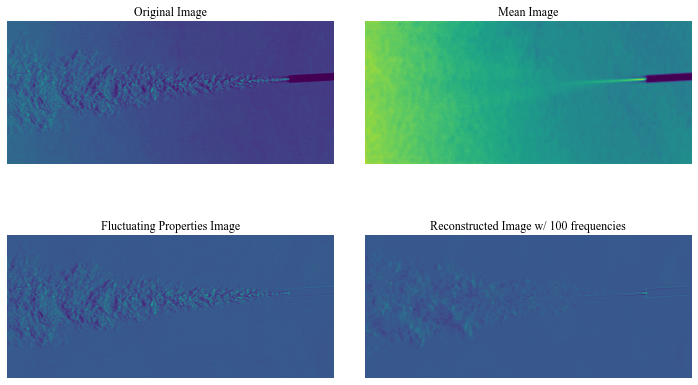

In [7]:
# Plotting sample images
plt.rcParams['font.family'] = "Times New Roman"

figure1, axarr = plt.subplots(2,2)
figure1.set_size_inches(10,6)
figure1.tight_layout(pad=0.5)

axarr[0,0].imshow(np.reshape(IM_orig,(h,l),order='F')),axarr[0,0].set_title('Original Image'),axarr[0,0].axis('off')
axarr[0,1].imshow(np.reshape(IM_av,(h,l),order='F')),axarr[0,1].set_title('Mean Image'),axarr[0,1].axis('off')
axarr[1,0].imshow(np.reshape(IM_fl,(h,l),order='F')),axarr[1,0].set_title('Fluctuating Properties Image'),axarr[1,0].axis('off')
axarr[1,1].imshow(IM_rec),axarr[1,1].set_title('Reconstructed Image w/ '+ str(end_sel - beg_sel) +' frequencies'),axarr[1,1].axis('off')

<ipython-input-8-8dcb1a84c207>:14: ComplexWarning: Casting complex values to real discards the imaginary part
  IMp[count5,:] = np.fft.ifft(Fq[:,1])


Execution time :89.24s


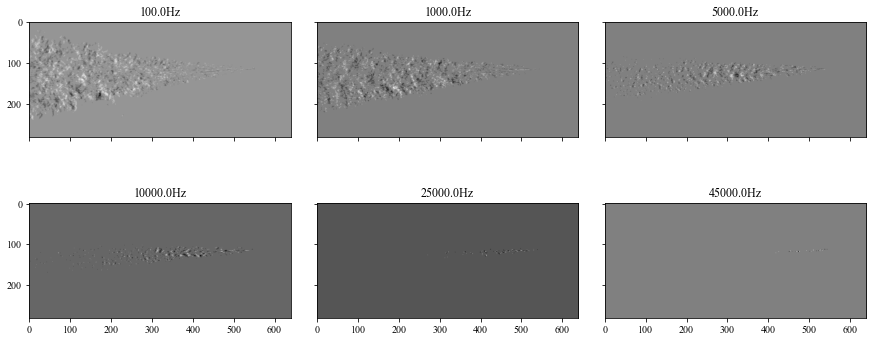

In [8]:
# PLotting reconstructions of certain frequencies
begin_time = time.time()
RF = [1, 10, 50, 100, 250, 450]                  # Frequencies to reconstruct
IMp = np.zeros((h*l,1000),dtype = np.int8)
IMp1 = np.zeros((h*l,6),dtype = np.int8)

for count4 in range(6):
    for count5 in range(h*l):
        Fq = np.zeros((1000,2), dtype = complex)
        Fq[:,0] = np.fft.fftfreq(1000,ts)              # Frequencies (np.fft.fftfreq)
        Fq[:,1] = np.fft.fft(IM2[count5,0:1000])              # Calculating FFT
        Fq[np.absolute(Fq[:,0]) < np.absolute(Fq[RF[count4],0])] = 0
        Fq[np.absolute(Fq[:,0]) > np.absolute(Fq[RF[count4],0])] = 0
        IMp[count5,:] = np.fft.ifft(Fq[:,1])
    IMp1[:,count4] = IMp[:,1]

Fq = np.zeros((1000,2), dtype = complex)
Fq[:,0] = np.fft.fftfreq(1000,ts)              # Frequencies (np.fft.fftfreq)

plt.rcParams['font.family'] = "Times New Roman"

fig, axs = plt.subplots(2,3, figsize=(15, 6),sharex=True,sharey=True)
fig.subplots_adjust(hspace = .25, wspace=.1) 
axs[0,0].imshow(np.reshape(IMp1[:,0],(h,l),order='F'), cmap='gray'), axs[0,0].set_title(str(Fq[RF[0],0].real)+'Hz')
axs[0,1].imshow(np.reshape(IMp1[:,1],(h,l),order='F'), cmap='gray'), axs[0,1].set_title(str(Fq[RF[1],0].real)+'Hz')
axs[0,2].imshow(np.reshape(IMp1[:,2],(h,l),order='F'), cmap='gray'), axs[0,2].set_title(str(Fq[RF[2],0].real)+'Hz')
axs[1,0].imshow(np.reshape(IMp1[:,3],(h,l),order='F'), cmap='gray'), axs[1,0].set_title(str(Fq[RF[3],0].real)+'Hz')
axs[1,1].imshow(np.reshape(IMp1[:,4],(h,l),order='F'), cmap='gray'), axs[1,1].set_title(str(Fq[RF[4],0].real)+'Hz')
axs[1,2].imshow(np.reshape(IMp1[:,5],(h,l),order='F'), cmap='gray'), axs[1,2].set_title(str(Fq[RF[5],0].real)+'Hz')

#del(IM2,IMp,IMp1)
#plt.subplots_adjust(top=2, bottom=0.2, left=0, right =2.5, hspace=0.25,wspace=.25) # Rescaling subplots
print('Execution time :'+ str(round(time.time() - begin_time,2))+'s')

 ### ---------------------------------------- FREQUENCY CORRELATIONS --------------------------------------

(-100.0, 5000.0)

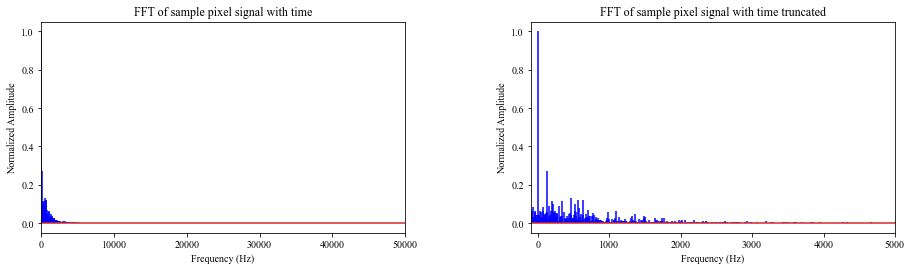

In [9]:
# PLotting a sample frequency band from 1 pixel in the image set
f = np.fft.fftfreq(im_imp,ts)       # Setting the Required Frequency

plt.rcParams['font.family'] = "Times New Roman"

figure3, ax3 = plt.subplots(1,2)
figure3.set_size_inches(15,6)
figure3.tight_layout(pad=10.0)

ax3[0].stem(f,F1/F1.max(),'b',markerfmt='none')
ax3[0].set_title('FFT of sample pixel signal with time')
ax3[0].set_ylabel('Normalized Amplitude')
ax3[0].set_xlabel('Frequency (Hz)')
#ax3.set_yscale('log')
#ax3.set_xscale('log')
ax3[0].set_xlim([-100,50000])

ax3[1].stem(f,F1/F1.max(),'b',markerfmt='none')
ax3[1].set_title('FFT of sample pixel signal with time truncated')
plt.ylabel('Normalized Amplitude')
plt.xlabel('Frequency (Hz)')
#ax3[1].set_yscale('log')
#ax3.set_xscale('log')
ax3[1].set_xlim([-100,5000])

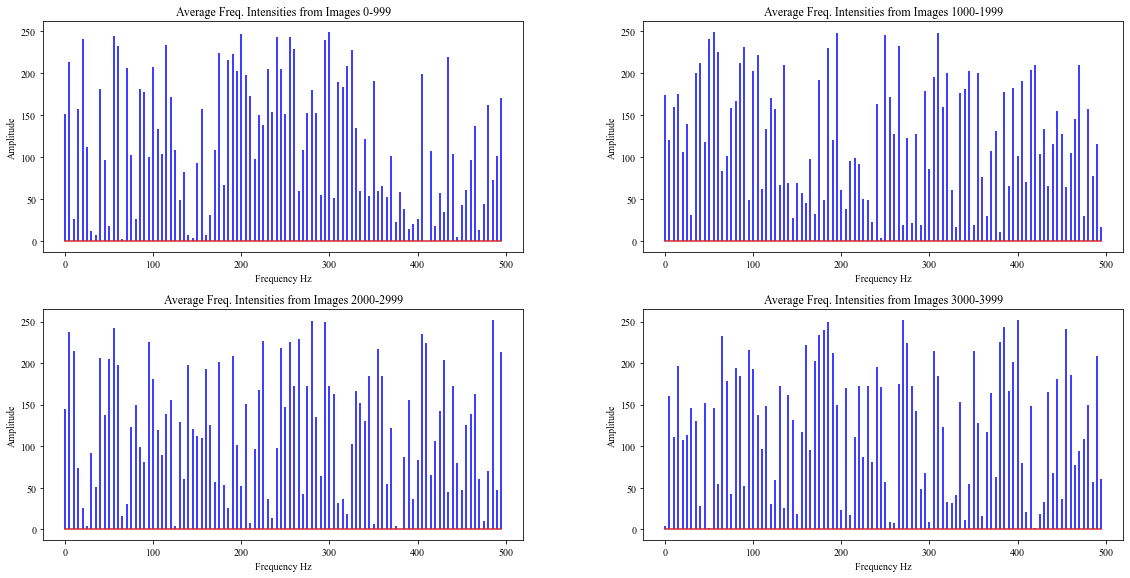

In [10]:
# Correlating Average frequency's from separate blocks of data

B1 = IM_fs0.toarray()               # Convert first sparse array back to regular array
B1 = np.int8(B1.sum(axis=1)/(2*(end_sel-beg_sel)+1))+128

B2 = IM_fs1.toarray()               # Convert first sparse array back to regular array
B2 = np.int8(B2.sum(axis=1)/(2*(end_sel-beg_sel)+1))+128

B3 = IM_fs2.toarray()               # Convert first sparse array back to regular array
B3 = np.int8(B3.sum(axis=1)/(2*(end_sel-beg_sel)+1))+128

B4 = IM_fs3.toarray()               # Convert first sparse array back to regular array
B4 = np.int8(B4.sum(axis=1)/(2*(end_sel-beg_sel)+1))+128

B5 = IM_fs4.toarray()               # Convert first sparse array back to regular array
B5 = np.int8(B5.sum(axis=1)/(2*(end_sel-beg_sel)+1))+128

plt.rcParams['font.family'] = "Times New Roman"

plt.subplot(221)
plt.stem(f[beg_sel:end_sel],B1[beg_sel:end_sel],'b',markerfmt='none')
plt.title('Average Freq. Intensities from Images 0-999')
plt.ylabel('Amplitude')
plt.xlabel('Frequency Hz')

plt.subplot(222)
plt.stem(f[beg_sel:end_sel],B2[beg_sel:end_sel],'b',markerfmt='none')
plt.title('Average Freq. Intensities from Images 1000-1999')
plt.ylabel('Amplitude')
plt.xlabel('Frequency Hz')

plt.subplot(223)
plt.stem(f[beg_sel:end_sel],B3[beg_sel:end_sel],'b',markerfmt='none')
plt.title('Average Freq. Intensities from Images 2000-2999')
plt.ylabel('Amplitude')
plt.xlabel('Frequency Hz')

plt.subplot(224)
plt.stem(f[beg_sel:end_sel],B4[beg_sel:end_sel],'b',markerfmt='none')
plt.title('Average Freq. Intensities from Images 3000-3999')
plt.ylabel('Amplitude')
plt.xlabel('Frequency Hz')

# the line below is used to adjus the positions of the subplots.
plt.subplots_adjust(top=2, bottom=0.2, left=0, right =2.5, hspace=0.25,wspace=.25) # Rescaling subplots

In [11]:
# Calculating Correlation Coefficients between signals
Correlation = np.zeros((5,6))
Correlation = pd.DataFrame(Correlation,columns =['a','0-999', '1000-1999', '2000-2999', '3000-3999', '4000-4999'])
Correlation.a =['0-999', '1000-1999', '2000-2999', '3000-3999', '4000-4999']
M =[B1, B2, B3, B4, B5]

for c1 in range(5):
    for c2 in range(5):
        Correlation.iat[c1,c2+1] = np.corrcoef(M[c1],M[c2])[0,1]

Correlation       

,a,0-999,1000-1999,2000-2999,3000-3999,4000-4999
0,0-999,1.000000,0.140953,0.106824,-0.062371,-0.036772
1,1000-1999,0.140953,1.000000,0.117050,-0.122472,-0.040393
2,2000-2999,0.106824,0.117050,1.000000,-0.149019,-0.053501
3,3000-3999,-0.062371,-0.122472,-0.149019,1.000000,0.038382
4,4000-4999,-0.036772,-0.040393,-0.053501,0.038382,1.000000


In [12]:
print('Execution time :'+ str(round(time.time() - begin_time_overall,2))+'s')

Execution time :1893.96s
